In [1]:
from utils import *

import cellxgene_census
from cellxgene_census.experimental.ml import ExperimentDataPipe, experiment_dataloader
import somacore as soma
from somacore import AxisQuery
import torch
from torch.utils.data import DataLoader
torch.ones(2).cuda();

In [2]:
root = '/mnt/nvme/s3/cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma'
census = cellxgene_census.open_soma(uri=root)

#reference = ln.Collection.filter(uid="1gsdckxvOvIjQgeDVS1F").one().reference
reference = '283d65eb-dd53-496d-adb7-7570c7caa443'
query_collection_id = f"collection_id == '{reference}'"
datasets =(census["census_info"]["datasets"]
           .read(column_names=["dataset_id"], value_filter=query_collection_id)
           .concat().to_pandas())["dataset_id"].tolist()
datasets[:10]

['8e10f1c4-8e98-41e5-b65f-8cd89a887122',
 'b165f033-9dec-468a-9248-802fc6902a74',
 'ff7d15fa-f4b6-4a0e-992e-fd0c9d088ded',
 'fe1a73ab-a203-45fd-84e9-0f7fd19efcbd',
 'fbf173f9-f809-4d84-9b65-ae205d35b523',
 'fa554686-fc07-44dd-b2de-b726d82d26ec',
 'f9034091-2e8f-4ac6-9874-e7b7eb566824',
 'f8dda921-5fb4-4c94-a654-c6fc346bfd6d',
 'f7d003d4-40d5-4de8-858c-a9a8b48fcc67',
 'f6d9f2ad-5ec7-4d53-b7f0-ceb0e7bcd181']

In [3]:
len(datasets)

138

In [4]:
experiment = census["census_data"]["homo_sapiens"]
experiment

<Experiment 'file:///mnt/nvme/s3/cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma/census_data/homo_sapiens' (open for 'r') (2 items)
    'ms': 'file:///mnt/nvme/s3/cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma/census_data/homo_sapiens/ms' (unopened)
    'obs': 'file:///mnt/nvme/s3/cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma/census_data/homo_sapiens/obs' (unopened)>

In [5]:
BATCH_SIZE = 1024
n_vars = 20_000
SOMA_CHUNK_SIZE = 10_000

In [6]:
@dataclass
class Exp:
    datapipe: ExperimentDataPipe
    loader: DataLoader

In [7]:
def get_exp_datapipe(start=None, n=None) -> Exp:
    start = start or 0
    end = len(datasets) if n is None else start + n
    ds = datasets[start:end]
    query_datasets = "dataset_id in " + str(ds)
    experiment_datapipe = ExperimentDataPipe(
        experiment,
        measurement_name="RNA",
        X_name="raw",
        obs_query=AxisQuery(value_filter=query_datasets),
        var_query=AxisQuery(coords=(slice(n_vars-1),)),
        batch_size=BATCH_SIZE,
        shuffle=True,
        soma_chunk_size=SOMA_CHUNK_SIZE,
    )
    
    loader = experiment_dataloader(experiment_datapipe)
    return Exp(experiment_datapipe, loader)

Initialize loaders for the first 10 datasets

In [8]:
%%time
exps = [ get_exp_datapipe(start=i, n=1) for i in range(10) ]

CPU times: user 4.8 ms, sys: 255 µs, total: 5.05 ms
Wall time: 4.92 ms


First 10 dataset lengths:

In [9]:
%%time
[ exp.datapipe.shape[0] for exp in exps ]

CPU times: user 1min 17s, sys: 20.8 s, total: 1min 38s
Wall time: 5.5 s


[2480956, 888263, 28051, 35285, 17660, 29674, 23120, 31899, 155025, 6877]

In [10]:
n_epochs = 1
# n_epochs = 5

results = {"Merlin": {}, "MappedCollection": {}, "cellxgene_census": {}}
for epoch in range(n_epochs):
    for k in results:
        results[k][f"epoch_{epoch}"] = {}

In [11]:
def benchmark(exp: Exp):
    n_samples = exp.datapipe.shape[0]
    loader_iter = exp.loader.__iter__()
    # exclude first batch from benchmark as this includes the setup time
    batch = next(loader_iter)
    
    num_iter = n_samples // BATCH_SIZE if n_samples is not None else None
    
    start_time = time.time()
    
    batch_times = []
    batch_time = time.time()
    
    total = num_iter if num_iter is not None else len(loader_iter)
    for i, batch in tqdm(enumerate(loader_iter), total=total):
        X = batch["x"] if isinstance(batch, dict) else batch[0] 
        # for pytorch DataLoader
        # Merlin sends to cuda by default
        if hasattr(X, "is_cuda") and not X.is_cuda:
            X = X.cuda()
        
        if num_iter is not None and i == num_iter:
            break
        if i % 10 == 0:
            gc.collect()

        batch_elapsed = time.time() - batch_time
        # print(f'Batch {i:04d} took {batch_elapsed:.2f}')
        batch_times.append(batch_elapsed)
        batch_time = time.time()
    
    execution_time = time.time() - start_time
    gc.collect()
    
    time_per_sample = (1e6 * execution_time) / (total * BATCH_SIZE)
    print(f'time per sample: {time_per_sample:.2f} μs')
    samples_per_sec = total * BATCH_SIZE / execution_time
    print(f'samples per sec: {samples_per_sec:.2f} samples/sec')
    
    return samples_per_sec, time_per_sample, batch_times

In [12]:
%%time
exp = get_exp_datapipe(start=2, n=5)
exp.datapipe.shape[0]

CPU times: user 7.83 s, sys: 2.15 s, total: 9.99 s
Wall time: 545 ms


133790

## Run benchmark

In [13]:
%%time
for epoch in range(n_epochs):
    samples_per_sec, time_per_sample, batch_times = benchmark(exp)
    results["cellxgene_census"][f"epoch_{epoch}"]["time_per_sample"] = time_per_sample
    results["cellxgene_census"][f"epoch_{epoch}"]["samples_per_sec"] = samples_per_sec
    results["cellxgene_census"][f"epoch_{epoch}"]["batch_times"] = batch_times

100%|██████████████████| 130/130 [01:12<00:00,  1.80it/s]


time per sample: 541.57 μs
samples per sec: 1846.49 samples/sec
CPU times: user 1min 37s, sys: 48.9 s, total: 2min 26s
Wall time: 1min 16s


In [14]:
results_json_path = 'results-local.json'
with open(results_json_path, 'w') as f:
    json.dump(results, f, indent=2)

In [15]:
# with open(results_json_path, 'r') as f:
#     results = json.load(f)

## Plot batch timings

In [16]:
method = 'cellxgene_census'
epoch = 0
df = pd.DataFrame(
    {
        'time': results[method][f'epoch_{epoch}']['batch_times'],
    },
)
df.index.name = 'idx'
df['res'] = df.index % 10
df['res_str'] = df.res.astype('str') + 'mod10'
df = df.reset_index()
df

,idx,time,res,res_str
0,0,0.613416,0,0mod10
1,1,0.256815,1,1mod10
2,2,0.250808,2,2mod10
3,3,0.246755,3,3mod10
4,4,0.241966,4,4mod10
...,...,...,...,...
125,125,0.113792,5,5mod10
126,126,0.111463,6,6mod10
127,127,0.109159,7,7mod10
128,128,0.111219,8,8mod10


In [17]:
ann = df[df.time > .5]
ann

,idx,time,res,res_str
0,0,0.613416,0,0mod10
8,8,4.086326,8,8mod10
10,10,0.673394,0,0mod10
17,17,1.463308,7,7mod10
20,20,0.689228,0,0mod10
26,26,4.177011,6,6mod10
30,30,0.739352,0,0mod10
36,36,3.676944,6,6mod10
40,40,0.881639,0,0mod10
45,45,2.642899,5,5mod10


In [18]:
pc

PlotConfigs(fmt='fig', w=1200, h=800, save=[], v=True, i=None, dir=None, grid='#ccc', bg='white')

Saving: benchmark-batch-times-local.png
Returning IPython Image


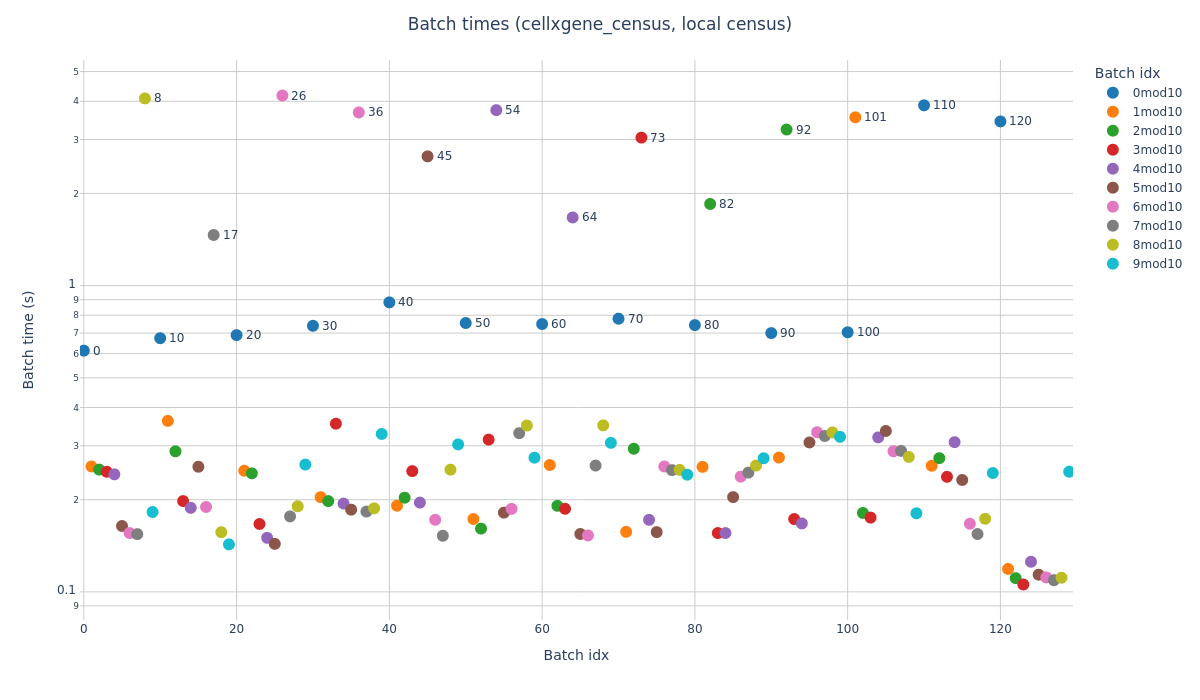

In [19]:
fig = px.scatter(
    df,
    x='idx',
    y='time',
    # text='time',
    color='res_str',
    color_discrete_sequence=default_colors,
    labels={ 'time': 'Batch time (s)', 'res_str': 'Batch idx', 'idx': 'Batch idx', },
    log_y=True,
).update_layout(
    title=dict(text=f'Batch times ({method}, local census)'),
).update_xaxes(
    range=(-.5, len(df) - 1 + .5),
).update_traces(
    marker=dict(
        size=12,
    )
)

anns = ann.set_index('idx').time.to_dict().items()
for idx, time in anns:
    fig.add_annotation(
        x=idx, y=log10(time),
        showarrow=False,
        text=f'{idx}',
        xshift=7,
        xanchor='left',
    )

plot(fig, 'benchmark-batch-times-local', fmt='png', save=['png'], w=1200, h=700,)